
# Analytical Excersice


*Rama Krishna*

---

**Objectives**

To answer
*	What do the different distributions of requests by user tell us?

*   Did the new creative increase conversions?
*   Would retargeting have improved performance for this campaign?



## Setup

First, let's get the data, import required modules.

In [1]:
import os
import numpy as np
import pandas as pd
import json
import google
from pandas.io.json import json_normalize
from statsmodels.stats.proportion import proportions_ztest
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm


#setting the working directory
#drive.mount('/content/drive')
#os.chdir("/content/drive/My Drive/Valassis/")


### Importing Data
* **bid_requests** - Each row represents a bid request that we have seen for the targeted users. 


* **User_attributes** - Each row represents a of unique target user attributes

In [2]:
bid_df = pd.read_csv("C:\\Users\\kommi\\Downloads/bid_requests.csv")
user_df = pd.read_csv("C:\\Users\\kommi\\Downloads/user_attributes.csv")
bid_df.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In the user_df we see that column attributes contains a json format
let's normalize to get columns
* Normalizing json files



In [4]:
user_df = user_df.join(json_normalize(user_df['attributes'].map(json.loads).tolist())).drop(['attributes'],axis=1)
user_df.head(2)

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1


In [5]:
bid_user=pd.merge(bid_df, user_df, on='user_id', how='inner')
bid_user['datetime']=pd.to_datetime(bid_user['timestamp'])
bid_user['dow']=bid_user['datetime'].dt.day_name()
bid_user['hod']=bid_user['datetime'].dt.hour
bid_user.head()

,timestamp,user_id,bid,win,conversion,age,gender,location,test,datetime,dow,hod
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1,2017-01-01 00:00:01,Sunday,0
1,2017-01-01 15:39:10,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1,2017-01-01 15:39:10,Sunday,15
2,2017-01-01 18:44:07,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1,2017-01-01 18:44:07,Sunday,18
3,2017-01-02 08:55:04,be7485be5b6eb3690efcbc9e95e8f15a,1,1,0,25,M,TN,1,2017-01-02 08:55:04,Monday,8
4,2017-01-02 13:10:56,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0,25,M,TN,1,2017-01-02 13:10:56,Monday,13


In [6]:
# filtering requests based on win
bid_user_conv = bid_user[bid_user['win']==1]
pd.DataFrame(bid_user_conv.groupby(['test','conversion']).size())

0
test conversion       
0    0           62841
     1            2723
1    0           81203
     1            3392

## What do the different distributions of requests by user tell us?

Wins vs users

In [7]:
df0 = bid_user[bid_user['test']==0]
df1 = bid_user[bid_user['test']==1]

#### Tri plot helper

In [8]:
def tri_plot(variable,df0=df0,df1=df1):
  """
  Generates 3 plots(bid,win,conversion) by given variable
  """
  fig = plt.figure(figsize=(21,7))
  ax = fig.add_subplot(131)
  pd.value_counts(df0[variable],normalize=True).sort_index().plot(kind="bar",color='red', ax=ax, position=0, width=0.25,alpha=0.6)
  pd.value_counts(df1[variable],normalize=True).sort_index().plot(kind="bar",color='blue', ax=ax, position=1, width=0.25,alpha=0.6)
  ax.axhline(pd.value_counts(bid_user[variable],normalize=True).mean(), color='green', linewidth=2)
  ax.set_title(variable+ ' vs bid proportions')
  ax.set_xlabel(variable)
  ax.set_ylabel('bid proportion')
  ax.grid(axis='y')
  ax.legend(['avg bid proportion','t0','t1'],loc='lower left')


  ax1 = fig.add_subplot(132)
  pd.value_counts(df0[df0['win']==1][variable],normalize=True).sort_index().plot(kind="bar",color='red', ax=ax1, position=0, width=0.25,alpha=0.6)
  pd.value_counts(df1[df1['win']==1][variable],normalize=True).sort_index().plot(kind="bar",color='blue', ax=ax1, position=1, width=0.25,alpha=0.6)
  ax1.axhline(pd.value_counts(bid_user[bid_user['win']==1][variable],normalize=True).mean(), color='green', linewidth=2)
  ax1.set_title(variable +' vs win proportions')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('win proportion')
  ax1.grid(axis='y')
  ax1.legend(['avg win proportion','t0','t1'],loc='lower left')

  ax2 = fig.add_subplot(133)
  pd.value_counts(df0[df0['conversion']==1][variable],normalize=True).sort_index().plot(kind="bar",color='red', ax=ax2, position=0, width=0.25,alpha=0.6)
  pd.value_counts(df1[df1['conversion']==1][variable],normalize=True).sort_index().plot(kind="bar",color='blue', ax=ax2, position=1, width=0.25,alpha=0.6)
  ax2.axhline(pd.value_counts(bid_user_conv[bid_user_conv['conversion']==1][variable],normalize=True).mean(), color='green', linewidth=2)
  ax2.set_title(variable + ' vs conversion proportions')
  ax2.set_xlabel(variable)
  ax2.set_ylabel('conversion proportion')
  ax2.grid(axis='y')
  ax2.legend(['avg conversion proportion','t0','t1'],loc='lower left')
  plt.show()

def conversion(variable,df0=df0,df1=df1):
  """ Takes a column and returns 
  conversion rate by column variables"""

  x = (df0[df0['win']==1].groupby(['conversion',variable])[variable].size()).unstack()
  y = (df1[df1['win']==1].groupby(['conversion',variable])[variable].size()).unstack()

  x.loc['conversion rate test_0'] = x.loc[1]/x.loc[0]
  y.loc['conversion rate test_1'] = y.loc[1]/y.loc[0]
  res = pd.concat([x,y]).drop([0,1],axis=0)
  res.loc['difference'] = y.loc['conversion rate test_1'] - x.loc['conversion rate test_0']
  res.loc['Percent_diff'] = ((y.loc['conversion rate test_1'] - x.loc['conversion rate test_0'])/x.loc['conversion rate test_0'])*100

  return res


### Gender

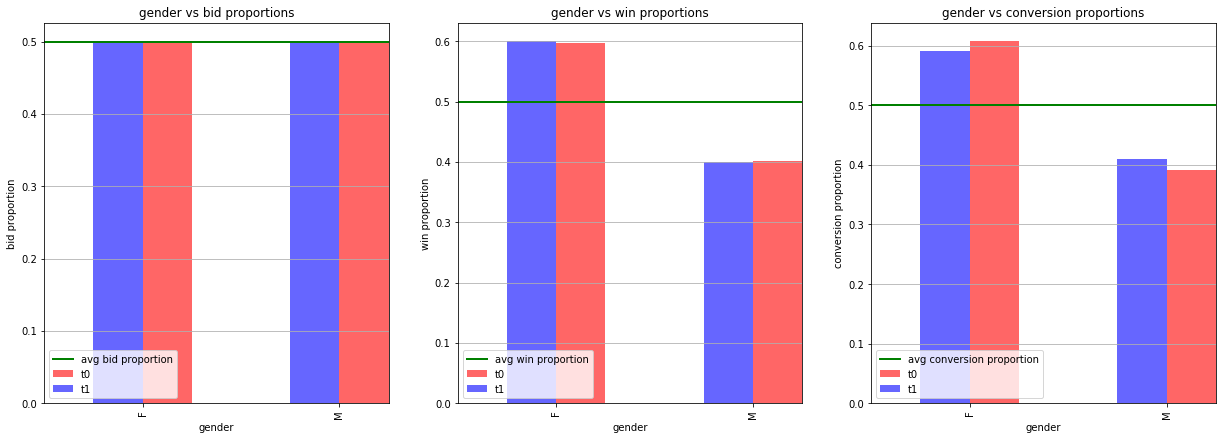

gender,F,M
conversion,,
conversion rate test_0,0.044104,0.042186
conversion rate test_1,0.041020,0.042906
difference,-0.003084,0.000721
Percent_diff,-6.991915,1.708025


In [9]:
tri_plot('gender')
conversion('gender')

About 60% of wins and conversions came from Female. But there isn't a large difference between conversion rates.

### Age

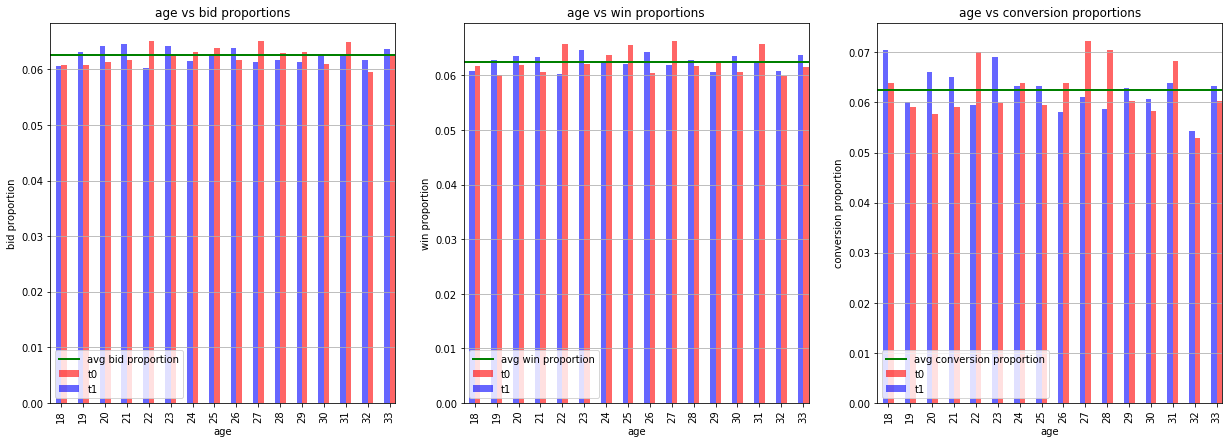

age,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
conversion,,,,,,,,,,,,,,,,
conversion rate test_0,0.044915,0.042660,0.040215,0.042246,0.046393,0.041741,0.043500,0.039140,0.045886,0.047413,0.049870,0.041890,0.041601,0.045058,0.038085,0.042334
conversion rate test_1,0.048756,0.039898,0.043470,0.042996,0.041241,0.044716,0.042398,0.042676,0.037567,0.041178,0.038943,0.043275,0.039868,0.042945,0.037134,0.041530
difference,0.003841,-0.002762,0.003255,0.000750,-0.005152,0.002975,-0.001102,0.003536,-0.008319,-0.006235,-0.010927,0.001385,-0.001733,-0.002113,-0.000951,-0.000804
Percent_diff,8.551283,-6.474423,8.093115,1.775262,-11.104436,7.126905,-2.533450,9.033690,-18.130408,-13.150712,-21.910674,3.306087,-4.165404,-4.690283,-2.496917,-1.898406


In [10]:
tri_plot('age')
conversion('age')

Both the tests affected some age groups, some groups are affected positively and some negatively.

### Location

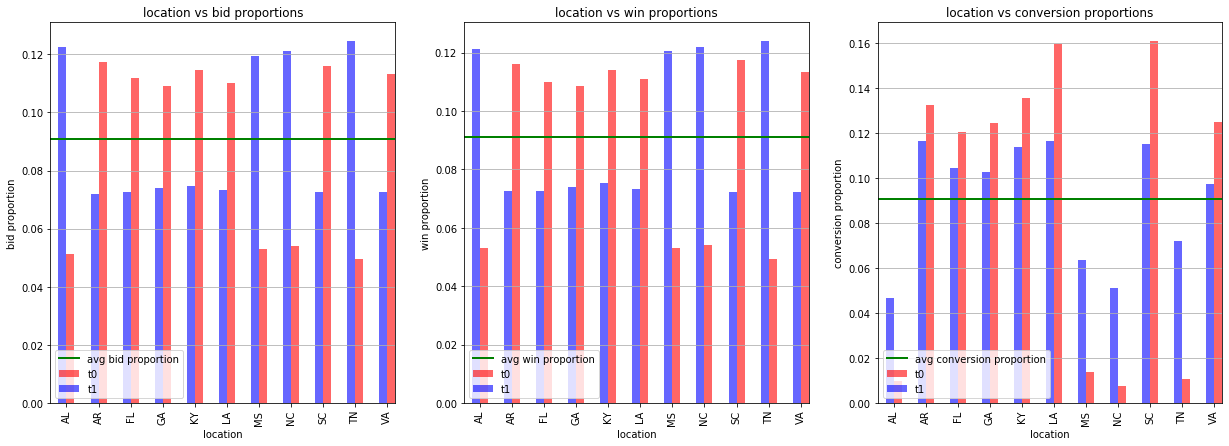

location,AL,AR,FL,GA,KY,LA,MS,NC,SC,TN,VA
conversion,,,,,,,,,,,
conversion rate test_0,0.007523,0.049800,0.047744,0.050096,0.051921,0.063587,0.010743,0.005655,0.060377,0.009054,0.047914
conversion rate test_1,0.015661,0.068732,0.061087,0.058963,0.064398,0.067951,0.021560,0.017088,0.068416,0.023893,0.057257
difference,0.008137,0.018932,0.013343,0.008867,0.012477,0.004364,0.010817,0.011434,0.008040,0.014839,0.009342
Percent_diff,108.165786,38.015161,27.947768,17.699215,24.031077,6.862937,100.686246,202.203181,13.315716,163.895334,19.497746


In [11]:
tri_plot('location')
conversion('location')

Both the tests have users from different locations.  Win and conversion proportions dosen't look to follow a trend.

### Day of week

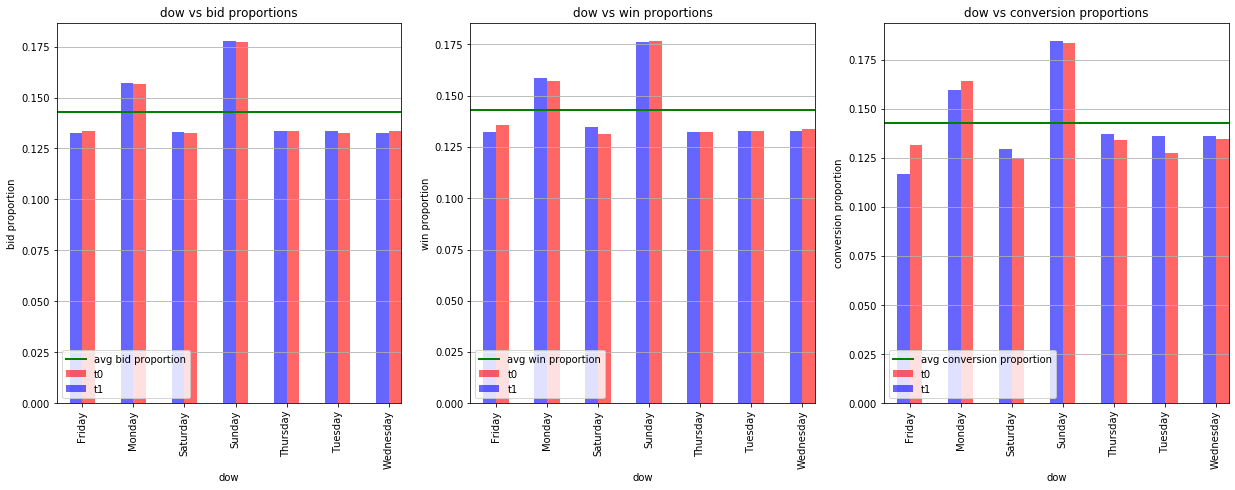

dow,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
conversion,,,,,,,
conversion rate test_0,0.041886,0.045303,0.041172,0.045004,0.043907,0.041458,0.043701
conversion rate test_1,0.036626,0.042068,0.040128,0.043877,0.043397,0.042792,0.042828
difference,-0.005260,-0.003235,-0.001045,-0.001126,-0.000510,0.001335,-0.000873
Percent_diff,-12.558052,-7.140535,-2.536949,-2.502306,-1.161207,3.219143,-1.997525


In [12]:
tri_plot('dow')
conversion('dow')

Sundays and Mondays have highest bids, wins and convertions in both the tests. Test 1 affected negatively on conversions on most of the days.

### Hour of the day

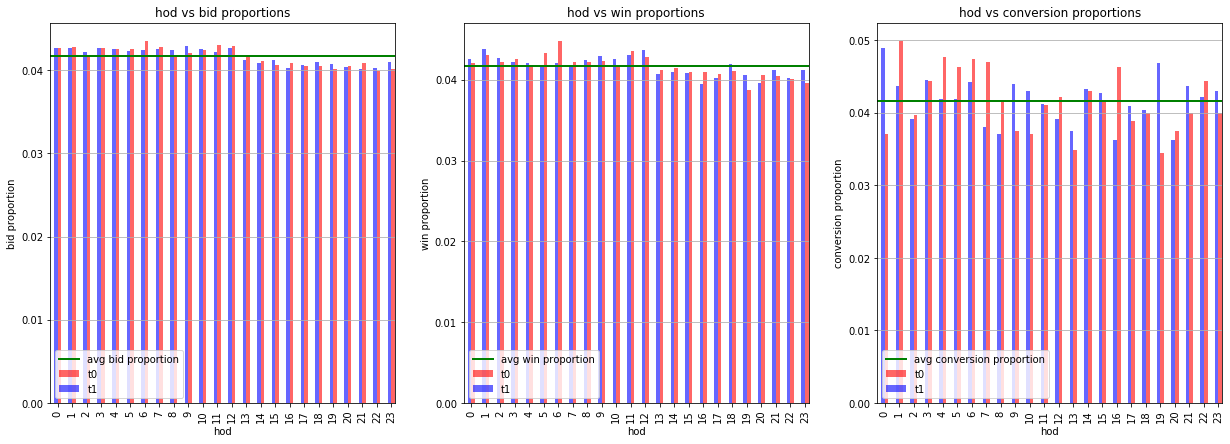

hod,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
conversion,,,,,,,,,,,,,,,,,,,,,
conversion rate test_0,0.037970,0.050652,0.040693,0.045267,0.050000,0.046426,0.045907,0.048466,0.042625,0.038231,...,0.044965,0.043952,0.049257,0.041309,0.042150,0.038493,0.039922,0.042896,0.048323,0.043810
conversion rate test_1,0.048368,0.041608,0.038251,0.044178,0.041533,0.041839,0.044014,0.038098,0.036353,0.042828,...,0.044277,0.043846,0.038306,0.042586,0.040211,0.048579,0.038163,0.044325,0.043892,0.043791
difference,0.010398,-0.009044,-0.002442,-0.001090,-0.008467,-0.004587,-0.001893,-0.010368,-0.006272,0.004598,...,-0.000688,-0.000105,-0.010951,0.001276,-0.001939,0.010086,-0.001759,0.001428,-0.004431,-0.000019
Percent_diff,27.385816,-17.854603,-6.000810,-2.407043,-16.934776,-9.881116,-4.124359,-21.393006,-14.714879,12.025655,...,-1.530738,-0.239770,-22.233098,3.089738,-4.599543,26.202781,-4.404921,3.329294,-9.169038,-0.043478


In [13]:
tri_plot('hod')
conversion('hod')

* Most of the bids and wins were from 0-12. But the conversions dosent seem to follow the trend.

* Test 0 performed better than Test 1 during some hours and Test 1 during other hours

##Did the new creative increase conversions?

### Conversion Data

We ran two different versions of a creative, a and b, for which we count the number of users and whether they convert or not. We can summarize this in a contingency table showing the frequency distribution of the events:

In [14]:
data = pd.DataFrame({
    'version': ['A', 'B'],
    'not_converted': [62841, 81203],
    'converted': [2723, 3392],
})[['version', 'not_converted', 'converted']]
data['conv_rate'] = data['converted']/(data['converted']+data['not_converted'])
print("Total ads shown:",len(bid_user[bid_user['win']==1]))
print("="*30)
print(bid_user_conv.groupby(['test'])['conversion'].size())
data

Total ads shown: 150159
test
0    65564
1    84595
Name: conversion, dtype: int64


,version,not_converted,converted,conv_rate
0,A,62841,2723,0.041532
1,B,81203,3392,0.040097


It is trivial to compute the conversion rate of each version, 4.153% for a and 4.009% for b. With such a relatively small difference, however, can we convincingly say that the version b converts better? To test the statistical significance of a result like this, a hypothesis testing can be used.

### Comparing Two Proportions

The Hypothesis Testing is a statistical test used to determine whether the hypothesis assumed for the sample of data stands true for the entire population or not. Simply, the hypothesis is an assumption which is tested to determine the relationship between two data sets.



Let's formalize our thought process a little bit, suppose that we have obtained data from n visitors,  nA  of which have been sent to converts A, and  nB  of which have been sent to converts B. Further, let  XA  and  XB  denote the number of visitors for whom we obtained a 'successful' outcome in the two groups. The proportion of successes in the two groups is then given by  pA^=XA/nA  and  pB^=XB/nB  respectively. The estimated difference in success rates is then give by the difference in proportions:  pA^−pB^ :

To assess whether we have statistical evidence that the two converts' success rates truely differ, we can perform a hypothesis test. The null hypothesis that we want to test is that the two converts' true success rates are equal, whereas the alternative is that they differ (one is higher than the other). If  pA  = the proportion of the page A population whom we obtained a successful outcome and  pB  = the proportion of the page B population whom we obtained a successful outcome then we are interested in testing the following hypothesis:

Hypothesis | Condition
--- | ---
H0 | pA>=pB
HA | pA<pB


A test statistic is a single metric that can be used to evaluate the null hypothesis and the standard way to obtain this metric is to compute the z-score that measures how many standard deviations below or above the population mean a raw score is

$z=\frac{x-μ}{SE}$


Where:

* μ  denotes the mean
*SE  or sometimes seen as the symbol  σ  denotes the standard error, computed by  s/√n , where  s  denotes the standard error and  n  denotes the number of samples


For our test the underlying metric is a binary yes/no variable (event), which means the appropriate test statistic is a test for differences in proportions:

$Z=\frac{(pA^−pB^)−(pA−pB)}{SE(pA−pB)}$

$Z = \frac{(pA^−pB^)−0}{√p^(1−p^)(1/nA+1/nB)}$

where Where  p^=(XA+XB)/(nA+nB)



#### Calculating the Statistic

In [15]:
zscore, pvalue = proportions_ztest(data['converted'], (data['converted']+data['not_converted']), alternative = 'smaller')
print('zscore = {:.3f}, pvalue between = {:.3f}, pvalue beyond = {:.3f}'.format(zscore,pvalue,1-pvalue))

zscore = 1.395, pvalue between = 0.919, pvalue beyond = 0.081


Based on the fact that our p-value is not smaller than the 0.05 commonly used threshold, the test statistic tells us we do not have strong evidence against our null hypothesis, i.e. we do not have strong evidence that the creative 1 was better than creative 0.

### A Regression Approach

In this final part, we will confirm that the result acheived in the previous A/B test can also be acheived by performing logistic regression. I will use statsmodels to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [16]:
df = bid_user_conv[['test','conversion']]
df['intercept'] = 1

In [17]:
log = sm.Logit(df['conversion'], df[['intercept', 'test']])
results = log.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.170230
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:               150159
Model:                          Logit   Df Residuals:                   150157
Method:                           MLE   Df Model:                            1
Date:                Sat, 19 Dec 2020   Pseudo R-squ.:               3.803e-05
Time:                        15:29:31   Log-Likelihood:                -25562.
converged:                       True   LL-Null:                       -25563.
Covariance Type:            nonrobust   LLR p-value:                    0.1632
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.1389      0.020   -160.356      0.000      -3.177      -3.101
test          -0.0367      0.

Regression analysis I

* The p-value associated with test is 0.16 we fail to reject the null hyphothesis because these two p-values are greater than 0.05(Type Error I).



### AB Testing Summary

To answer wheather the test users more likely to convert than control users, we performed the following tests: 
* A/B test with z-test and logistic regression models. In the z-test, we found the p-value is higher than type I error, and because of this we fails to reject the null hypothesis i.e prove that control users were more likely to convert.
* After that, we fit the regression model and again failed to reject the null hypothesis.
* p-value of reg analysis is different from results in Hypothesis Test because the null hypothesis is different. 

1. In Z-test, null=new page is not better than old page, alternative=new page is better. So Z-test is a one-sided test. 
2. Here, we hope to find out that conversion depends on which landing page users use. The alternative here is that conversion rates are different, and null is there is no difference. So this is a two-sided test

### [Updated] But..

When we take a look at the conversion rate by each state and test.

In [18]:
loc = conversion('location')
loc.loc['proportion of requests_t0']=pd.value_counts(df0[df0['conversion']==1]['location'],normalize=True).sort_index()
loc.loc['proportion of requests_t1']=pd.value_counts(df1[df1['conversion']==1]['location'],normalize=True).sort_index()
loc.loc['prop_difference'] = loc.loc['proportion of requests_t1'] - loc.loc['proportion of requests_t0']
loc.loc['Percent_diff_prop'] = ((loc.loc['proportion of requests_t1'] - loc.loc['proportion of requests_t0'])/loc.loc['proportion of requests_t0'])*100
loc


location,AL,AR,FL,GA,KY,LA,MS,NC,SC,TN,VA
conversion,,,,,,,,,,,
conversion rate test_0,0.007523,0.049800,0.047744,0.050096,0.051921,0.063587,0.010743,0.005655,0.060377,0.009054,0.047914
conversion rate test_1,0.015661,0.068732,0.061087,0.058963,0.064398,0.067951,0.021560,0.017088,0.068416,0.023893,0.057257
difference,0.008137,0.018932,0.013343,0.008867,0.012477,0.004364,0.010817,0.011434,0.008040,0.014839,0.009342
Percent_diff,108.165786,38.015161,27.947768,17.699215,24.031077,6.862937,100.686246,202.203181,13.315716,163.895334,19.497746
proportion of requests_t0,0.009548,0.132574,0.120455,0.124495,0.135512,0.159750,0.013588,0.007345,0.161219,0.010650,0.124862
proportion of requests_t1,0.046580,0.116450,0.104363,0.102889,0.113797,0.116450,0.063384,0.051002,0.115271,0.072229,0.097583
prop_difference,0.037032,-0.016124,-0.016092,-0.021606,-0.021715,-0.043300,0.049796,0.043658,-0.045948,0.061579,-0.027280
Percent_diff_prop,387.837899,-12.162151,-13.359447,-17.354821,-16.024473,-27.104682,366.475172,594.397111,-28.500330,578.203277,-21.847860


* From the above we see that there is a clear increase in conversion rate in each state.
* But the hypothesis test failed to detect this because there is a huge differences in the proportions of record from each states.

## Would retargeting have improved performance for this campaign?

### Data

In [19]:
#Keeping required columns
retarget_df = bid_user_conv.drop(['bid','win','datetime','dow','hod','age','location','gender'],axis=1)

In [20]:
# Seperating test0 and test 1 data
retarget_df_0 = retarget_df[retarget_df['test']==0].sort_values(['user_id','timestamp'])
retarget_df_1 = retarget_df[retarget_df['test']==1].sort_values(['user_id','timestamp'])

### get_prev_conv helper

In [21]:
def get_previous_convert(retarget_df_0_or_1):
  # Calculating cummulative conversion for each user
  conversion_cum = retarget_df_0_or_1.groupby(by=['user_id','timestamp'])['conversion'].sum().groupby(level=[0]).cumsum().reset_index().sort_values(['user_id','timestamp']).conversion
  retarget_df_0_or_1.reset_index(drop=True,inplace=True)
  retarget_df_0_or_1['cumm_conversion'] = conversion_cum
  # Creating prev_conv column
  retarget_df_0_or_1['prev_conv'] = np.where(retarget_df_0_or_1['cumm_conversion']>0,1,0)
  for index,row in retarget_df_0_or_1.iterrows():
    if row['conversion']==1 and row['cumm_conversion']==1:
      retarget_df_0_or_1.loc[index,'prev_conv']=0
  return retarget_df_0_or_1 


### Adding prev_conv
For every request we add a new column called prev_conv which says wheter the user previously converted or not (1 or 0)

In [22]:
retarget_df_0 = get_previous_convert(retarget_df_0)
retarget_df_1 = get_previous_convert(retarget_df_1)

In [23]:
retarget_df_0[69:76]

,timestamp,user_id,conversion,test,cumm_conversion,prev_conv
69,2017-01-10 19:53:34,003a8eb4813be2f8c5ad692ff1866162,0,0,0,0
70,2017-01-07 15:39:09,003ae4e8b9f59b0aa0910ba1f5e35735,1,0,1,0
71,2017-01-15 20:53:13,003ae4e8b9f59b0aa0910ba1f5e35735,0,0,1,1
72,2017-01-03 06:08:18,003bed21fddc817050c8fa11897fe660,0,0,0,0
73,2017-01-12 06:00:33,003bed21fddc817050c8fa11897fe660,0,0,0,0
74,2017-01-16 09:00:40,003bed21fddc817050c8fa11897fe660,1,0,1,0
75,2017-01-04 02:24:44,003da94355a506f1f294090c173e7b73,0,0,0,0


### Convertion rates of new users and already converted users.

* New User is someone who has not converted.
* Old User is someone who converted at least once before.


In [24]:
print("Test 0")
x = retarget_df_0.groupby(['prev_conv','conversion'])['conversion'].size().unstack()
x[2] = x[1]/(x[0]+x[1])
x.columns = ['not_converted','converted','conversion_rate']
x.index=["New User","Old User"]
x

Test 0


,not_converted,converted,conversion_rate
New User,59191,2495,0.040447
Old User,3650,228,0.058793


In [25]:
print("Test 1")
y = retarget_df_1.groupby(['prev_conv','conversion'])['conversion'].size().unstack()
y[2] = y[1]/(y[0]+y[1])
y.columns = ['not_converted','converted','conversion_rate']
y.columns = ['not_converted','converted','conversion_rate']
y

Test 1


,not_converted,converted,conversion_rate
prev_conv,,,
0,76716,3112,0.038984
1,4487,280,0.058737


### Statistical Test

Should we consider retargeting users that have previously converted?

- p0 - Conversion rate of new users
- p1 - Conversion rate of already converted users.

- **Null Hypothesis**: conversion rate of already converted users less than or equal to new users. (p0 <= p1)
- **Alternative Hypothesis**: conversion rate of already converted users is greater than convertion rate of new users. (p0 > p1)

In [26]:
zscore, pvalue = proportions_ztest(x['converted'], (x['not_converted']+x['converted']), alternative = 'larger')
print('Test 0:\nzscore = {:.3f}, pvalue between = {:.3f}'.format(zscore,pvalue))
zscore, pvalue = proportions_ztest(y['converted'], (y['not_converted']+y['converted']), alternative = 'larger')
print('Test 1:\nzscore = {:.3f}, pvalue between = {:.3f}'.format(zscore,pvalue))

Test 0:
zscore = -5.554, pvalue between = 1.000
Test 1:
zscore = -6.753, pvalue between = 1.000


* From the above hypothesis tests we fail to reject the null hypothesis
* Which means we failed to prove that conversion rate of new users is better than old users.
* So we should consider retargeting users who have previously converted..

## Next Steps

* There are a lot of interesting things to look at when we are working on this kind of data.
* So asking the right questions which generate value is very important.